<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-рассемплирование-данных" data-toc-modified-id="Загрузка-и-рассемплирование-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и рассемплирование данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-разных-моделей-с-различными-гиперпараметрами" data-toc-modified-id="Обучение-разных-моделей-с-различными-гиперпараметрами-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение разных моделей с различными гиперпараметрами</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Проверка-данны-на-тестовой-выборке" data-toc-modified-id="Проверка-данны-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка данны на тестовой выборке</a></span></li></ul></div>

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Цель: значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Загрузка и рассемплирование данных

In [1]:
# загружаю нужные библиотеки
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
# загружаю файл
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('/Users/dariasokolovska/Downloads/taxi.csv')

In [3]:
# проверяю данные на дубликаты
df.duplicated().sum()

0

In [4]:
# делаю дату и время индексом
df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)

# удаляю столбец datetime
df.drop('datetime', axis=1, inplace=True)


In [5]:
# cортирую данные по индексу
df.sort_index(inplace=True)

In [6]:
# изучаю данные
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

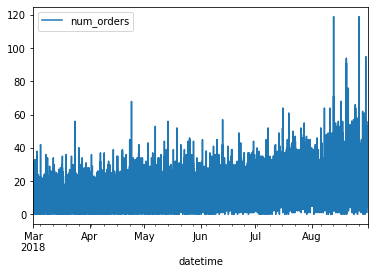

In [7]:
df.plot()

In [8]:
# выполняю почасовой ресамплинг
df_resampled = df.resample('1H').sum()

Вывод:

Полученные данные чистые, без дубликатов. На графике видно, что есть значения, похожие на выбросы, но в данном задании их нельзя считать таковыми, так как данные выбросы могут показывать высокий спрос на такси. Так же я выполнила ресемплирование данных с интервалом в 1 час для дальнейшего анализа.

## Анализ

Ежедневно наблюдаются пиковые значения. Рассмотрим данные в 2 интервалах - 1 день и 1 неделя:

<AxesSubplot:xlabel='datetime'>

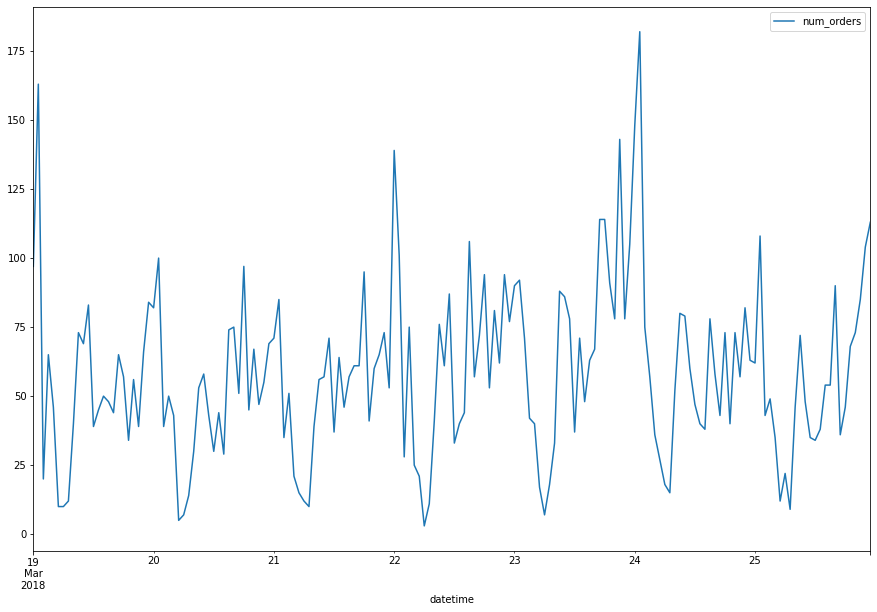

In [9]:
# интервал в 1 неделю
df_resampled['2018-03-19':'2018-03-25'].plot(figsize = (15,10))

<AxesSubplot:xlabel='datetime'>

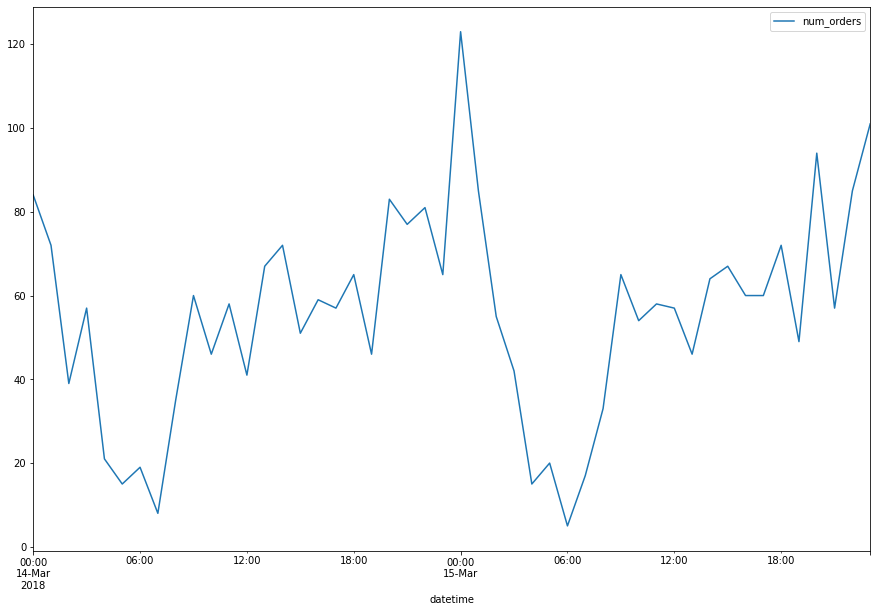

In [10]:
# интервал в 1 день
df_resampled['2018-03-14':'2018-03-15'].plot(figsize = (15,10))

Вывод:

Пик заказов приходится на полночь. Минимальное количество заказов приходится на период с 4 до 6 утра.
В течении дня количество заказов колеблется достаточно равномерно.
Так же можно заметить большое количество заказов в полночь с воскресенья на понедельник и с пятницы на субботу, и немного меньше со среды на четверг.

In [11]:
# изучим тренды и сезонность на отрезке в 1 неделю
decomposed = seasonal_decompose(df_resampled)['2018-03-19':'2018-03-25']

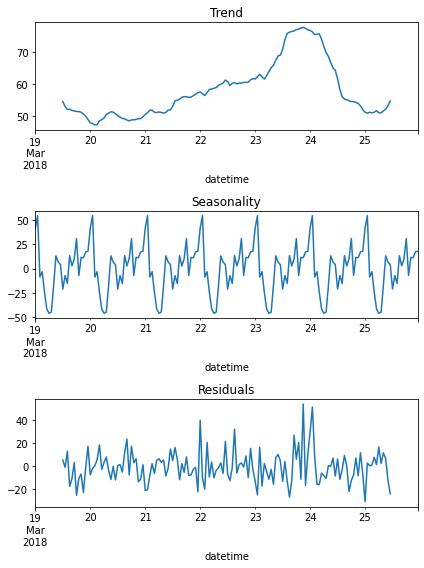

In [12]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

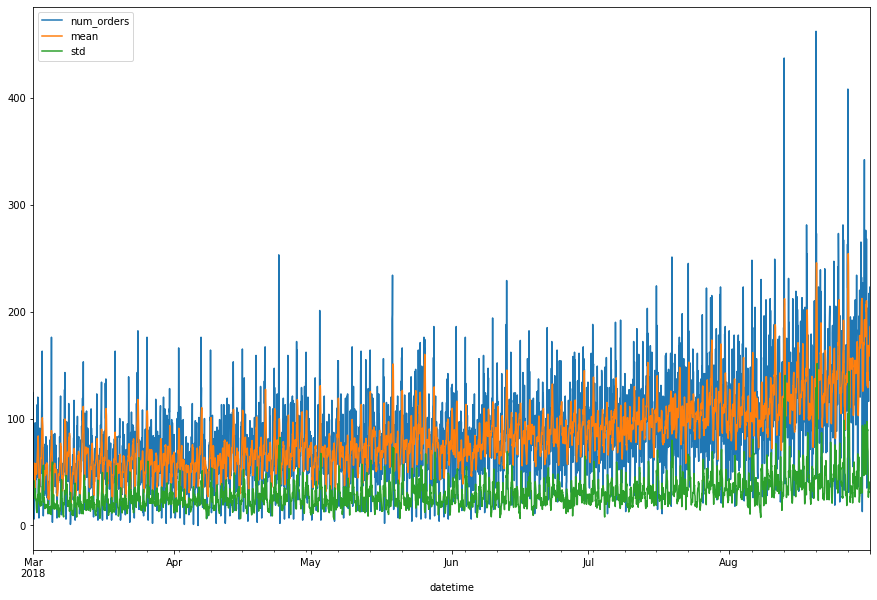

In [13]:
# Добавим скользящее стандартное отклонение и среднее
df_resampled['mean'] = df_resampled['num_orders'].rolling(7).mean()
df_resampled['std'] = df_resampled['num_orders'].rolling(7).std()
df_resampled.plot(figsize = (15,10))

График показывает, что среднее значение и стандартное отклонение со временем увеличиваются. Проверим данные на стацинарность

In [14]:
df_stat = df_resampled['num_orders'] - df_resampled['num_orders'].shift(fill_value=0)

In [15]:
df_stat = df_resampled - df_resampled.shift(fill_value=0)
df_stat

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,-39,NaN,NaN
2018-03-01 02:00:00,-14,NaN,NaN
2018-03-01 03:00:00,-5,NaN,NaN
2018-03-01 04:00:00,-23,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,-71,0.000000,0.000000
2018-08-31 20:00:00,18,-1.714286,0.325261
2018-08-31 21:00:00,5,3.714286,-2.373517


<AxesSubplot:xlabel='datetime'>

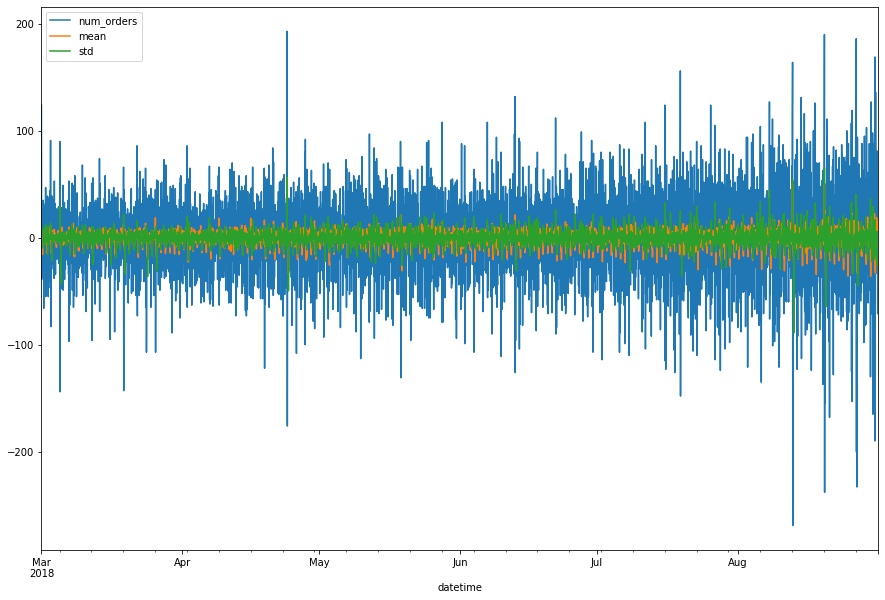

In [16]:
df_stat.plot(figsize = (15,10))

Теперь среднее не меняется, значит ряд стал стационарным и его можно спрогнозировать.

## Обучение разных моделей с различными гиперпараметрами

In [17]:
# генерирую новые признаки
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [18]:
# удалим столбцы, образовавшиеся во время анализа, но не нужные для обучения.
df_resampled = df_resampled.drop(['mean', 'std'], axis = 1)

In [19]:
make_features(df_resampled, 25, 25)

In [20]:
# удаляю пропущенные значения
df_resampled = df_resampled.dropna()

In [21]:
# выделяю целевой признак
features = df_resampled.drop(['num_orders'], axis = 1)
target = df_resampled['num_orders']

In [22]:
# делю выборки на тренировочную и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [23]:
tscv = TimeSeriesSplit(n_splits=5)

### LinearRegression

In [24]:
model = LinearRegression()
parametrs = {}
grid = GridSearchCV(model, parametrs, cv = tscv, scoring = 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
print('RMSE = ', abs(grid.best_score_))

RMSE =  27.01761950006926


### DecisionTreeRegressor

In [25]:
model = DecisionTreeRegressor()
parametrs = {'max_depth': range (5, 15, 1),'min_samples_leaf': range (45, 55, 11)}
grid = GridSearchCV(model, parametrs, cv = tscv, scoring = 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 11, 'min_samples_leaf': 45}

In [26]:
print('RMSE = ', abs(grid.best_score_))

RMSE =  29.227052024453798


### RandomForestRegressor

In [27]:
model = RandomForestRegressor()
parametrs = {'n_estimators': range (35, 45, 1), 'min_samples_leaf': range (1, 10, 1)}
grid = GridSearchCV(model, parametrs, cv = tscv, scoring = 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

{'min_samples_leaf': 2, 'n_estimators': 40}

In [28]:
print('RMSE = ', abs(grid.best_score_))

RMSE =  25.863188725585257


### LGBMRegressor

In [ ]:
model = LGBMRegressor()
parametrs = {'max_depth': range (6, 16, 1),'n_estimators': range (36, 46, 1)}
grid = GridSearchCV(model, parametrs, cv = tscv, scoring = 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

In [ ]:
print('RMSE = ', abs(grid.best_score_))

Вывод:
    
Лучшей моделью я считаю модель LGBMRegressor, так как она показала RMSE 25.68

## Проверка данны на тестовой выборке

In [ ]:
model = LGBMRegressor(random_state = 12345, max_depth = 9, n_estimators = 45)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test ,predictions)**0.5)

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(target_train, label = 'Обучающие данные')
plt.plot(target_test, 'g', label = 'Реальные данные', alpha = 0.5)
plt.plot(pd.Series(predictions, index = target_test.index), 'r', label = 'Предсказанные значения', alpha = 0.8)    
plt.title('LGBMRegressor', fontsize = 16)
plt.legend()    
plt.show()

Вывод:
    
При достаточно большом количестве созданных признаков модель линейной регресси удовлетворяет цели проекта - ее RMSE = 43.67 < 48.